In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import folium
from branca.colormap import linear, LinearColormap
import numpy as np
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from shapely import wkt
from shapely.geometry import mapping
from sklearn.decomposition import PCA
from factor_analyzer import Rotator
from sklearn.cluster import KMeans
import japanize_matplotlib
import matplotlib.colors as mcolors
from shapely.geometry.base import BaseGeometry
from pathlib import Path

In [2]:
def mashplot_from_geometry(
    datarate: pd.DataFrame,
    target: str = "地震z",
    geom_col: str = "geometry",
    tiles: str = "cartodbpositron",
    zoom_start: int = 10,
    etarget: str = "地震z",
):
    if geom_col not in datarate.columns:
        raise KeyError(f"datarate に {geom_col} 列がありません（WKTのPOLYGON/MultiPolygon 想定）。")
    if target not in datarate.columns:
        raise KeyError(f"datarate に {target} 列がありません。")

    # NaN除去
    df = datarate[[geom_col, target]].dropna(subset=[geom_col, target]).copy()

    # WKT -> shapely geometry
    df["__geom"] = df[geom_col].apply(wkt.loads)

    # 地図の初期中心（最初のジオメトリの重心）
    #centroid = df["__geom"].iloc[0].centroid
    # shapelyは (x=lon, y=lat)
    m = folium.Map(location=[35.088225, 138.372322], zoom_start=zoom_start, tiles=tiles)

    # カラーマップ
    vmin, vmax = float(df[target].min()), float(df[target].max())
    if np.isclose(vmin, vmax):
        vmin, vmax = vmin - 1e-6, vmax + 1e-6
    try:
        viridis = getattr(linear, "Viridis_256")
        colormap = viridis.scale(vmin, vmax)
    except Exception:
        colormap = LinearColormap(
            colors=["#440154", "#3b528b", "#21918c", "#5ec962", "#fde725"],
            vmin=vmin, vmax=vmax
        )
    colormap.caption = etarget
    colormap.add_to(m)

    # GeoJSON で一括追加（スタイル関数で色分け）
    # GeoJSON の properties に target 値を入れる
    features = []
    for _, row in df.iterrows():
        geom = row["__geom"]
        val = float(row[target])
        # shapely -> __geo_interface__ は (lon, lat) 順。Folium(Leaflet)もWGS84前提でOK。
        features.append({
            "type": "Feature",
            "geometry": mapping(geom),
            "properties": {
                target: val,
                "popup": f"{etarget}: {val:.3f}"
            }
        })

    gj = folium.GeoJson(
        {"type": "FeatureCollection", "features": features},
        style_function=lambda feat: {
            "fillColor": colormap(feat["properties"][target]),
            "color": None,
            "weight": 0,
            "fillOpacity": 0.6,
        },
        highlight_function=lambda feat: {
            "weight": 1,
            "color": "#666",
            "fillOpacity": 0.75,
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields=[target],
            aliases=[target + ":"],
            localize=True
        )
    )
    gj.add_to(m)

    # クリックでポップアップ（必要なら）
    folium.GeoJsonPopup(fields=["popup"]).add_to(gj)

    return m


In [3]:
datarate = pd.read_csv('../results/22_data_rate_データ整形.csv')
datarate.columns.to_list()

['MESH_ID',
 'SHICODE',
 'PTN_2020',
 'HITOKU2025',
 'GASSAN2025',
 'PTN_2025',
 'PT00_2025',
 'PT01_2025',
 'PT02_2025',
 'PT03_2025',
 'PT04_2025',
 'PT05_2025',
 'PT06_2025',
 'PT07_2025',
 'PT08_2025',
 'PT09_2025',
 'PT10_2025',
 'PT11_2025',
 'PT12_2025',
 'PT13_2025',
 'PT14_2025',
 'PT15_2025',
 'PT16_2025',
 'PT17_2025',
 'PT18_2025',
 'PT19_2025',
 'PT20_2025',
 'PTA_2025',
 'PTB_2025',
 'PTC_2025',
 'PTD_2025',
 'PTE_2025',
 'RTA_2025',
 'RTB_2025',
 'RTC_2025',
 'RTD_2025',
 'RTE_2025',
 'HITOKU2030',
 'GASSAN2030',
 'PTN_2030',
 'PT00_2030',
 'PT01_2030',
 'PT02_2030',
 'PT03_2030',
 'PT04_2030',
 'PT05_2030',
 'PT06_2030',
 'PT07_2030',
 'PT08_2030',
 'PT09_2030',
 'PT10_2030',
 'PT11_2030',
 'PT12_2030',
 'PT13_2030',
 'PT14_2030',
 'PT15_2030',
 'PT16_2030',
 'PT17_2030',
 'PT18_2030',
 'PT19_2030',
 'PT20_2030',
 'PTA_2030',
 'PTB_2030',
 'PTC_2030',
 'PTD_2030',
 'PTE_2030',
 'RTA_2030',
 'RTB_2030',
 'RTC_2030',
 'RTD_2030',
 'RTE_2030',
 'HITOKU2035',
 'GASSAN2035',

In [4]:
print('メッシュ数',len(datarate))
datarate = datarate[datarate['人口'] > 0].copy()
print('人が住んでいる場所のみ', len(datarate))

メッシュ数 11635
人が住んでいる場所のみ 11531


In [5]:
sociallabels = ['道路', '病院', '避難所','人口', '75歳以上人口比率', '0～14歳人口比率']
bakurolabels = ['津波', '洪水', '土砂', '地震']
esociallabels = [
    "Road accessibility",
    "Hospital",
    "Shelter",
    "Population",
    "Proportion aged 75+",
    "Proportion aged 0–14"
]

ebakurolabels = [
    "Tsunami",
    "Flood",
    "Landslide",
    "Seismic"
]

target_cols = sociallabels + bakurolabels
etarget_cols = esociallabels + ebakurolabels
datarate = datarate[['MESH_ID',"SHICODE","geometry", 'lon', 'lat'] + target_cols].copy()

In [6]:
# 標準化
scaler = StandardScaler()
datarate_z = scaler.fit_transform(datarate[target_cols])

# z変換後の列を追加
for i, col in enumerate(target_cols):
    datarate[col + 'z'] = datarate_z[:, i]

# 確認
#print(datarate.head())

In [7]:
#heatmap作成
for target_col, etarget_col in zip(target_cols,etarget_cols):
    m = mashplot_from_geometry(datarate, target_col, geom_col="geometry", etarget=etarget_col)
    m.save(f"../results/22_mesh_{target_col}.html")

    # ヘッドレスブラウザで開く
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    driver = webdriver.Chrome(options=options)

    driver.set_window_size(1200, 800)  # 必要に応じて調整
    driver.get(f"file:///Users/harukaohba/Library/CloudStorage/OneDrive-jtnd/研究/御前崎/202508_災害時医療物資配送のためのドローン基地最適配置モデルの提案/オープンデータメッシュ化/results/22_mesh_{target_col}.html")

    time.sleep(3)  # 読み込み待ち
    driver.save_screenshot(f"../results/22_mesh_{target_col}.png")
    driver.quit()

In [8]:
# 曝露列を初期化（0で作る）
datarate["曝露"] = 0.0

# 曝露計測：各バクロ指標の z 変換値を足す
for bakurolabel in bakurolabels:
    datarate["曝露"] += datarate[bakurolabel + "z"]

In [9]:
m = mashplot_from_geometry(datarate, "曝露", geom_col="geometry", etarget='risk')
m.save(f"../results/22_mesh_曝露.html")

# ヘッドレスブラウザで開く
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

driver.set_window_size(1200, 800)  # 必要に応じて調整
driver.get(f"file:///Users/harukaohba/Library/CloudStorage/OneDrive-jtnd/研究/御前崎/202508_災害時医療物資配送のためのドローン基地最適配置モデルの提案/オープンデータメッシュ化/results/22_mesh_曝露.html")

time.sleep(3)  # 読み込み待ち
driver.save_screenshot(f"../results/22_mesh_曝露.png")
driver.quit()

In [10]:
#社会的脆弱性
datarate["社会的脆弱性"] = 0.0
for sociallabel in sociallabels:
    if sociallabel != '道路':
        datarate["社会的脆弱性"] += datarate[sociallabel + "z"]
    else:
        datarate["社会的脆弱性"] -= datarate[sociallabel + "z"]

m = mashplot_from_geometry(datarate, "社会的脆弱性", geom_col="geometry", etarget='risk')
m.save(f"../results/22_mesh_社会的脆弱性.html")

# ヘッドレスブラウザで開く
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

driver.set_window_size(1200, 800)  # 必要に応じて調整
driver.get(f"file:///Users/harukaohba/Library/CloudStorage/OneDrive-jtnd/研究/御前崎/202508_災害時医療物資配送のためのドローン基地最適配置モデルの提案/オープンデータメッシュ化/results/22_mesh_社会的脆弱性.html")

time.sleep(3)  # 読み込み待ち
driver.save_screenshot(f"../results/22_mesh_社会的脆弱性.png")
driver.quit()

In [11]:
#リスク度
datarate['リスク度'] = datarate['曝露'] + datarate['社会的脆弱性']

m = mashplot_from_geometry(datarate, "リスク度", geom_col="geometry", etarget='risk')
m.save(f"../results/22_mesh_リスク度.html")

# ヘッドレスブラウザで開く
options = Options()
options.add_argument("--headless")
options.add_argument("--no-sandbox")
options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(options=options)

driver.set_window_size(1200, 800)  # 必要に応じて調整
driver.get(f"file:///Users/harukaohba/Library/CloudStorage/OneDrive-jtnd/研究/御前崎/202508_災害時医療物資配送のためのドローン基地最適配置モデルの提案/オープンデータメッシュ化/results/22_mesh_リスク度.html")

time.sleep(3)  # 読み込み待ち
driver.save_screenshot(f"../results/22_mesh_リスク度.png")
driver.quit()

In [12]:
def classify_and_plot(
    datarate, 
    exp_col="曝露", 
    svi_col="社会的脆弱性",    
    geom_col="geometry",
    html_path="../results/曝露x社会的脆弱性_9分割.html",
    use_quantiles=True          
):
    import pandas as pd
    import folium
    from shapely import wkt
    from shapely.geometry.base import BaseGeometry

    df = datarate.copy()

    if not isinstance(df[geom_col].iloc[0], BaseGeometry):
        df[geom_col] = df[geom_col].apply(wkt.loads)

    if use_quantiles:
        df["曝露_class"] = pd.qcut(df[exp_col], 3, labels=["LowE","MidE","HighE"], duplicates="drop")
        df["SVI_class"] = pd.qcut(df[svi_col], 3, labels=["LowS","MidS","HighS"], duplicates="drop")
    else:
        df["曝露_class"] = pd.cut(df[exp_col], 3, labels=["LowE","MidE","HighE"])
        df["SVI_class"] = pd.cut(df[svi_col], 3, labels=["LowS","MidS","HighS"])

    df["カテゴリ"] = df["曝露_class"].astype(str).str.cat(df["SVI_class"].astype(str), sep="_")

    cat_order = [
        "LowE_LowS","LowE_MidS","LowE_HighS",
        "MidE_LowS","MidE_MidS","MidE_HighS",
        "HighE_LowS","HighE_MidS","HighE_HighS",
    ]
    palette = [
        "#d4f0f0","#a6cee3","#1f78b4",
        "#b2df8a","#33a02c","#006400",
        "#fdbf6f","#ff7f00","#e31a1c",
    ]
    cmap = {c: palette[i % len(palette)] for i, c in enumerate(cat_order)}

    c = df[geom_col].iloc[0].centroid
    m = folium.Map(location=[35.088225, 138.372322], zoom_start=10, tiles="cartodbpositron")

    feats = []
    for _, r in df.iterrows():
        feats.append({
            "type": "Feature",
            "geometry": r[geom_col].__geo_interface__,
            "properties": {
                "category": r["カテゴリ"],
                "exp": float(r[exp_col]),
                "svi": float(r[svi_col]),
            }
        })

    gj = folium.GeoJson(
        {"type": "FeatureCollection", "features": feats},
        style_function=lambda f: {
            "fillColor": cmap.get(f["properties"]["category"], "#cccccc"),
            "color": None, "weight": 0.3, "fillOpacity": 0.65
        },
        tooltip=folium.features.GeoJsonTooltip(
            fields=["category","exp","svi"],
            aliases=["カテゴリ","曝露","社会的脆弱性"],
            localize=True
        ),
    )
    gj.add_to(m)

    legend_rows = [
        ("LowS", ["LowE_LowS","MidE_LowS","HighE_LowS"]),
        ("MidS", ["LowE_MidS","MidE_MidS","HighE_MidS"]),
        ("HighS",["LowE_HighS","MidE_HighS","HighE_HighS"]),
    ]
    html = ['<div style="position:fixed; top:20px; right:20px; background:white; padding:10px; border:1px solid #999; z-index:9999;">']
    html += ['<div style="font-weight:bold; margin-bottom:6px;">曝露 × 社会的脆弱性（3×3）</div>']
    html += ['<table style="border-collapse:collapse;">']
    html += ['<tr><th></th><th style="padding:2px 6px;">LowE</th><th style="padding:2px 6px;">MidE</th><th style="padding:2px 6px;">HighE</th></tr>']
    for row_label, cats in legend_rows:
        html.append(f'<tr><th style="padding:2px 6px; text-align:left;">{row_label}</th>')
        for ckey in cats:
            color = cmap.get(ckey, "#ccc")
            html.append(f'<td style="padding:2px 6px;"><span style="display:inline-block;width:14px;height:14px;background:{color};border:1px solid #666;"></span></td>')
        html.append('</tr>')
    html += ['</table><div style="margin-top:6px; font-size:12px;"></div></div>']#列＝曝露 (Low→High), 行＝社会的脆弱性 (Low→High)
    m.get_root().html.add_child(folium.Element("".join(html)))

    m.save(html_path)
    return m, html_path, df["カテゴリ"]


In [13]:
m, path, df = classify_and_plot(
    datarate,
    exp_col="曝露",
    svi_col="社会的脆弱性",   # ← あなたの列名に合わせる
    geom_col="geometry",
    html_path="../results/曝露x社会的脆弱性_9分割.html",
    use_quantiles=True          # 等間隔にしたいなら False
)
print("保存:", path)


保存: ../results/曝露x社会的脆弱性_9分割.html


In [14]:
datarate['カテゴリ'] = df.to_list()
datarate.to_csv(f"../results/22_data_rate_リスク度追加.csv", index=False, encoding='utf-8-sig')

In [15]:
datarate

,MESH_ID,SHICODE,geometry,lon,lat,道路,病院,避難所,人口,75歳以上人口比率,...,75歳以上人口比率z,0～14歳人口比率z,津波z,洪水z,土砂z,地震z,曝露,社会的脆弱性,リスク度,カテゴリ
0,513775983,22134,"POLYGON ((137.725 34.6625, 137.725 34.66666666...",137.728125,34.664583,13,6.189483,0.398599,394.7626,0.2274,...,-0.003787,-0.347955,10.655690,-0.399036,-0.672381,1.539111,11.123384,-1.386118,9.737267,HighE_LowS
1,513775984,22134,"POLYGON ((137.73125 34.6625, 137.73125 34.6666...",137.734375,34.664583,9,6.439745,0.841978,623.6769,0.2753,...,0.318988,-0.364775,8.104734,-0.399036,-0.672381,1.539111,8.572428,0.300447,8.872876,HighE_MidS
2,513775993,22134,"POLYGON ((137.7375 34.6625, 137.7375 34.666666...",137.740625,34.664583,10,6.729339,1.382903,637.9110,0.2274,...,-0.003787,-0.355601,6.713753,-0.399036,-0.672381,1.543601,7.185937,0.422585,7.608522,HighE_HighS
3,513776804,22134,"POLYGON ((137.75625 34.654166666666676, 137.75...",137.759375,34.656250,13,8.486151,1.103578,292.1434,0.2369,...,0.060229,-0.231742,8.113192,-0.399036,-0.672381,1.549979,8.591753,-0.523551,8.068202,HighE_MidS
4,513776812,22134,"POLYGON ((137.76875 34.65, 137.76875 34.654166...",137.771875,34.652083,8,9.583914,1.195279,88.7890,0.1754,...,-0.354190,-0.649190,11.944803,-0.399036,-0.672381,1.551792,12.425178,-0.982092,11.443086,HighE_LowS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11630,533821881,22101,"POLYGON ((138.225 35.56666666666667, 138.225 3...",138.228125,35.568750,0,52.301377,36.243878,1.9823,0.0000,...,-1.536126,-1.270010,-0.207488,-0.399036,-0.672381,-1.507334,-2.786240,34.609861,31.823622,LowE_HighS
11631,533900201,22344,"POLYGON ((139 35.35, 139 35.35416666666667, 13...",139.003125,35.352083,1,25.758562,1.290363,44.6758,0.4297,...,1.359415,-0.841859,-0.207488,-0.399036,0.075620,-1.290081,-1.820986,3.151259,1.330273,LowE_HighS
11632,533900203,22344,"POLYGON ((139 35.35416666666667, 139 35.358333...",139.003125,35.356250,5,26.214315,1.006657,211.3949,0.2081,...,-0.133841,0.052673,-0.207488,-0.399036,0.278020,-1.407088,-1.735592,2.218401,0.482808,LowE_HighS
11633,533900204,22344,"POLYGON ((139.00625 35.35416666666667, 139.006...",139.009375,35.356250,9,26.321320,1.530604,43.2743,0.2245,...,-0.023329,0.725483,-0.207488,-0.399034,-0.613702,-1.311830,-2.532054,2.667604,0.135550,LowE_HighS


,code,都道府県,市郡,区町村
0,22101,静岡県,静岡市,葵区
1,22102,静岡県,静岡市,駿河区
2,22103,静岡県,静岡市,清水区
3,22131,静岡県,浜松市,中区
4,22132,静岡県,浜松市,東区
5,22133,静岡県,浜松市,西区
6,22134,静岡県,浜松市,南区
7,22135,静岡県,浜松市,北区
8,22136,静岡県,浜松市,浜北区
9,22137,静岡県,浜松市,天竜区


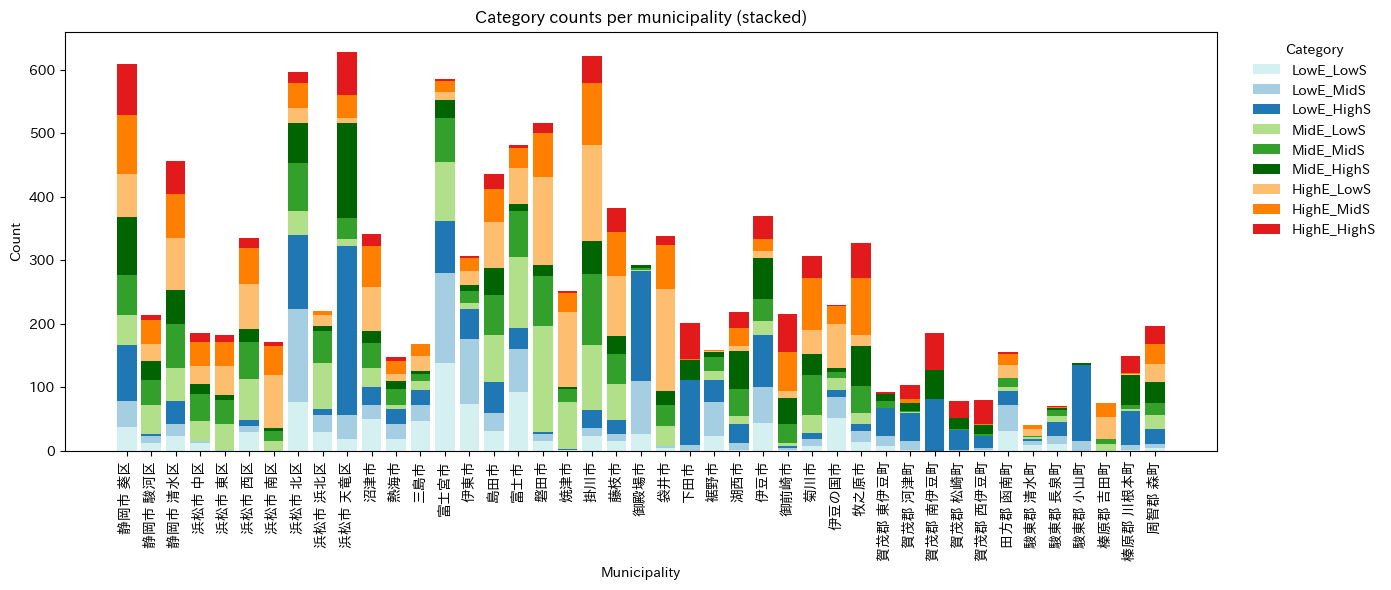

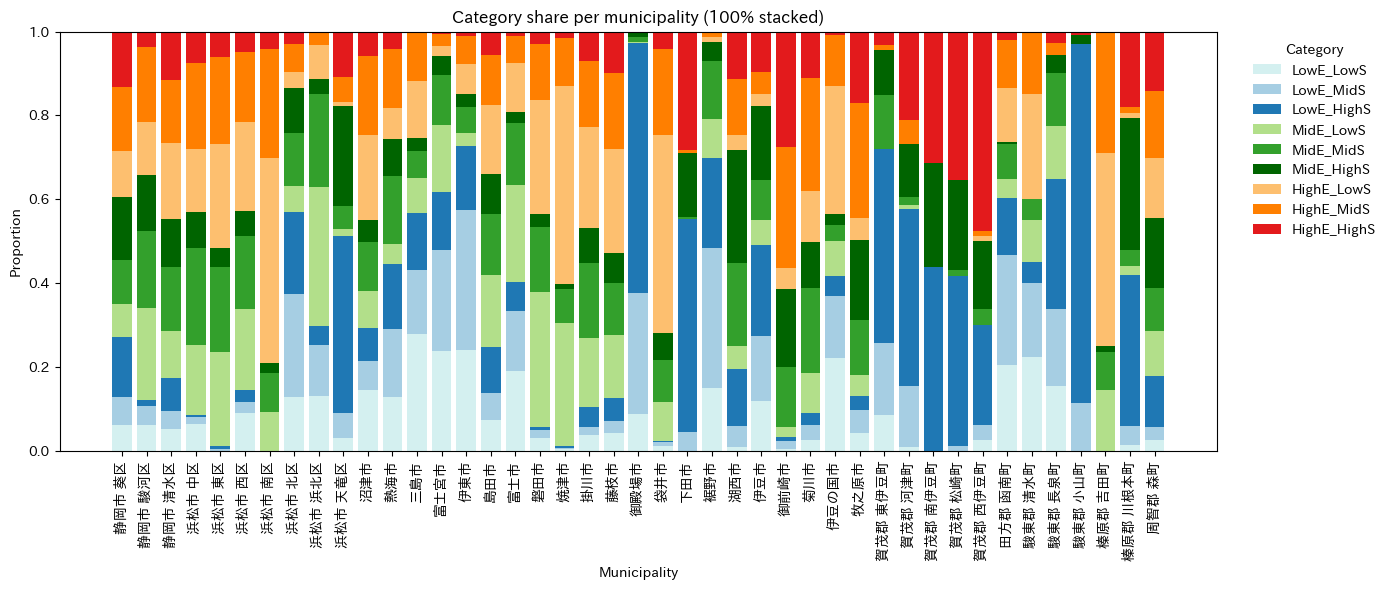

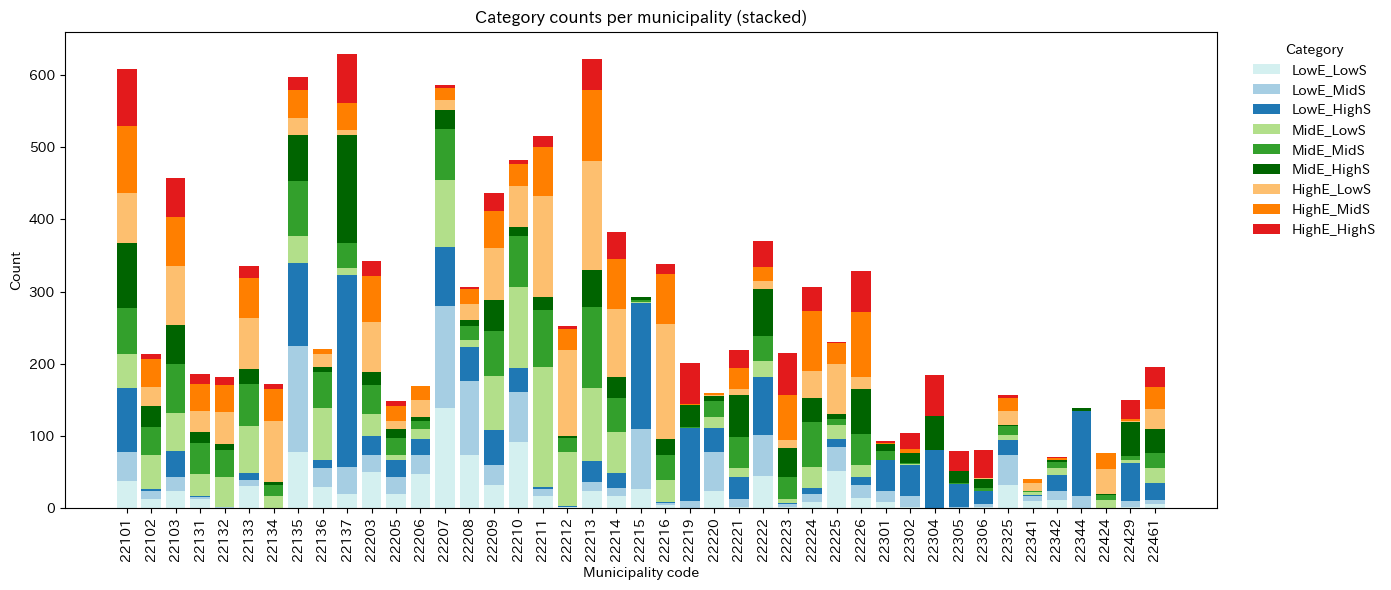

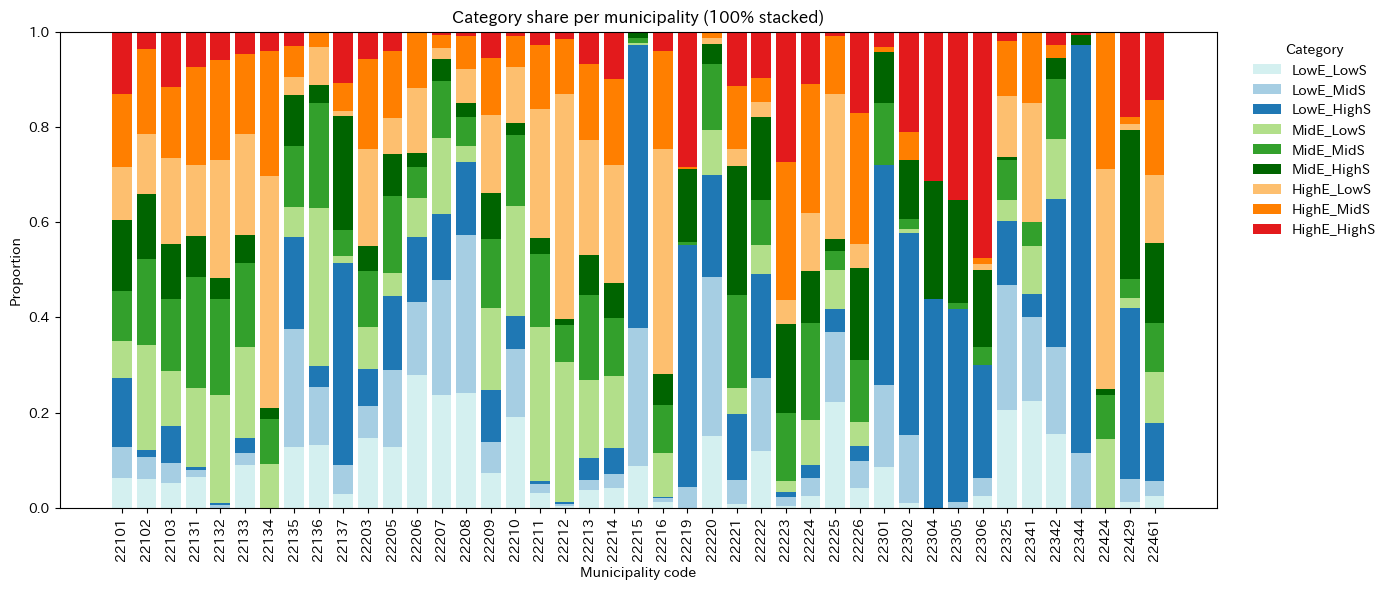

In [24]:
# ========= 設定 =========
# 1) 複合SHICODEの処理方法: "duplicate"（重複付与） or "share"（等分配）
MULTI_CODE_MODE = "duplicate"   # or "share"

# 2) 画像の保存設定（保存したくない場合は False）
SAVE_FIG = False
OUTDIR = Path(".figs")
OUTDIR.mkdir(parents=True, exist_ok=True)

# 3) 日本語フォント（環境に応じて。不要ならコメントアウト）
# plt.rcParams["font.family"] = "IPAexGothic"

# ========= 入力データ =========
# shicode（自治体コード→名称）
shicode = pd.read_csv('../data/000323625.csv', encoding='Shift-JIS')
display(shicode[shicode['都道府県'] =="静岡県"])
# datarate はロング形式を想定（例）
# datarate = pd.DataFrame({
#     "SHICODE": ["22101", "22101_22102", "22101_22103", "22101_22429"],
#     "カテゴリ": ["A", "A", "B", "C"]
# })

# 既に datarate がある前提ならこの行は不要
# datarate = datarate.copy()

# ========= 自治体名の作成・マッピング =========
# name = sityouson-name1 + sityouson-name2（NaN/空白に強く）
shicode['name'] = (
    shicode[['市郡', '区町村']]
    .fillna('')
    .agg(' '.join, axis=1)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)

# キー/値は文字列に
shicode['code'] = shicode['code'].astype('Int64').astype(str)
code_to_name = shicode.drop_duplicates('code').set_index('code')['name']

# ========= datarate 前処理（ロング形式）=========
datarate = datarate.copy()
datarate['SHICODE'] = datarate['SHICODE'].astype(str)

# 保険：必要カラムチェック
required_cols = {'SHICODE', 'カテゴリ'}
missing = required_cols - set(datarate.columns)
if missing:
    raise ValueError(f"必要な列が足りません: {missing}")

# 空や欠損を除去
datarate = datarate.dropna(subset=['SHICODE', 'カテゴリ'])
datarate = datarate[(datarate['SHICODE'].str.strip() != '') & (datarate['カテゴリ'].str.strip() != '')]

# 1レコード=1件の重み（shareの時に等分配する）
datarate['_weight'] = 1.0

# ========= 複合コード処理（duplicate or share）=========
codes_list = datarate['SHICODE'].str.split('_')

if MULTI_CODE_MODE == "share":
    # 等分配：1件を n 分割して配布（総件数は保存）
    n_parts = codes_list.str.len().replace(0, 1)
    df = datarate.copy()
    df['_weight'] = df['_weight'].div(n_parts, axis=0)
    df['SHICODE'] = codes_list
    expanded = df.explode('SHICODE', ignore_index=True)

elif MULTI_CODE_MODE == "duplicate":
    # 重複付与：各コードに同じ1件を数える（総件数は増える）
    df = datarate.copy()
    df['SHICODE'] = codes_list
    expanded = df.explode('SHICODE', ignore_index=True)

else:
    raise ValueError("MULTI_CODE_MODE は 'duplicate' か 'share' のみ有効です。")

# 再保険（空要素取り除き）
expanded = expanded.dropna(subset=['SHICODE', 'カテゴリ'])
expanded = expanded[(expanded['SHICODE'].str.strip() != '') & (expanded['カテゴリ'].str.strip() != '')]

# ========= 集計（SHICODE×カテゴリ）=========
counts = (
    expanded
    .groupby(['SHICODE', 'カテゴリ'], as_index=False)['_weight']
    .sum()
    .pivot(index='SHICODE', columns='カテゴリ', values='_weight')
    .fillna(0)
    .sort_index()
)

# ========= コード→自治体名へ置換（見つからなければコード）=========
mapped_names = [code_to_name.get(x, x) for x in counts.index]

# 重複名の自動回避（同名あればコードを添える）
seen = {}
uniq_names = []
for name, code in zip(mapped_names, counts.index):
    if name in seen:
        seen[name] += 1
        uniq_names.append(f"{name} ({code})")
    else:
        seen[name] = 1
        uniq_names.append(name)

counts.index = uniq_names

# ========= ふつうの積み上げ棒 =========
cat_order = [
    "LowE_LowS","LowE_MidS","LowE_HighS",
    "MidE_LowS","MidE_MidS","MidE_HighS",
    "HighE_LowS","HighE_MidS","HighE_HighS",
]
palette = [
    "#d4f0f0","#a6cee3","#1f78b4",
    "#b2df8a","#33a02c","#006400",
    "#fdbf6f","#ff7f00","#e31a1c",
]
cmap = {c: palette[i % len(palette)] for i, c in enumerate(cat_order)}
color_map = {c: palette[i] for i, c in enumerate(cat_order)}
GRADIENT = True  # False にすると単色

# counts の列を指定順に並べ替え（存在する列だけ）
cols_in_data = [c for c in cat_order if c in counts.columns]
counts = counts.reindex(columns=cols_in_data).fillna(0)

# 100% 用も同じ順序
row_sums = counts.sum(axis=1).replace(0, np.nan)
share = counts.div(row_sums, axis=0).fillna(0)
share = share.reindex(columns=cols_in_data)

def apply_vertical_gradient(ax, patch, color_hex, lighten=0.85):
    """棒パッチをクリップに使って、下=元色→上=やや明るい色 の縦グラデを重ね描き"""
    x, y = patch.get_x(), patch.get_y()
    w, h = patch.get_width(), patch.get_height()
    if h <= 0 or w <= 0:
        return
    base = mpl.colors.to_rgb(color_hex)
    top = tuple(min(1.0, c / lighten) for c in base)  # 上側を少し明るく
    N = 256
    grad = np.linspace(0, 1, N).reshape(N, 1)
    R = base[0] + (top[0]-base[0]) * grad
    G = base[1] + (top[1]-base[1]) * grad
    B = base[2] + (top[2]-base[2]) * grad
    img = np.dstack([R, G, B])  # N x 1 x 3
    im = ax.imshow(
        np.repeat(img, 2, axis=1),  # 幅2px
        extent=(x, x + w, y, y + h),
        aspect='auto',
        origin='lower',
        zorder=patch.get_zorder()+1,
        interpolation='bilinear',
    )
    im.set_clip_path(patch)
    im.set_clip_on(True)

def paint_gradient_bars(ax, cols_order, color_map, gradient=True):
    # pandas stacked bar のパッチ取得
    patches = [p for p in ax.patches if isinstance(p, mpl.patches.Rectangle)]
    n_bars = len(ax.get_xticks())
    n_cats = len(cols_order)
    # 想定外の順序に備えてソート保険（x→yで層順）
    if len(patches) != n_bars * n_cats:
        patches.sort(key=lambda p: (round(p.get_x(), 6), p.get_y()))
    for i_bar in range(n_bars):
        for j_cat, cat in enumerate(cols_order):
            idx = i_bar * n_cats + j_cat
            if idx >= len(patches):
                break
            patch = patches[idx]
            col = color_map.get(cat, "#999999")
            # まず棒自体は透明に
            patch.set_facecolor((0,0,0,0))
            patch.set_edgecolor((0,0,0,0))
            if gradient:
                apply_vertical_gradient(ax, patch, col)
            else:
                patch.set_facecolor(col)

# ---- 通常の積み上げ ----
# 1) カテゴリ順と色（下→上の順）
cat_order = [
    "LowE_LowS","LowE_MidS","LowE_HighS",
    "MidE_LowS","MidE_MidS","MidE_HighS",
    "HighE_LowS","HighE_MidS","HighE_HighS",
]
palette = [
    "#d4f0f0","#a6cee3","#1f78b4",
    "#b2df8a","#33a02c","#006400",
    "#fdbf6f","#ff7f00","#e31a1c",
]

# 2) counts 列を cat_order に合わせて並び替え（存在しない列は除外）
cols_in_data = [c for c in cat_order if c in counts.columns]
counts_o = counts.reindex(columns=cols_in_data).fillna(0)

# 3) 100%用
row_sums = counts_o.sum(axis=1).replace(0, np.nan)
share = counts_o.div(row_sums, axis=0).fillna(0)

# 4) 手動で積み上げ（通常の件数）
x = np.arange(len(counts_o))
labels = counts_o.index.tolist()

fig, ax = plt.subplots(figsize=(14, 6))
bottom = np.zeros(len(counts_o), dtype=float)

for cat, color in zip(cols_in_data, [palette[cat_order.index(c)] for c in cols_in_data]):
    vals = counts_o[cat].to_numpy(float)
    ax.bar(x, vals, bottom=bottom, color=color, edgecolor='none', label=cat)
    bottom += vals

ax.set_title('Category counts per municipality (stacked)')
ax.set_xlabel('Municipality')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)
ax.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

# 5) 手動で積み上げ（100%）
fig, ax2 = plt.subplots(figsize=(14, 6))
bottom = np.zeros(len(share), dtype=float)

for cat, color in zip(cols_in_data, [palette[cat_order.index(c)] for c in cols_in_data]):
    vals = share[cat].to_numpy(float)
    ax2.bar(x, vals, bottom=bottom, color=color, edgecolor='none', label=cat)
    bottom += vals

ax2.set_title('Category share per municipality (100% stacked)')
ax2.set_xlabel('Municipality')
ax2.set_ylabel('Proportion')
ax2.set_ylim(0, 1)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=90)
ax2.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()





# ========= コード→自治体名へ置換（見つからなければコード）=========
x = np.arange(len(counts_o))
#labels = counts_o.index.astype(str).tolist()  # codeをそのまま表示
labels = shicode[shicode['都道府県'] =="静岡県"]['code']

fig, ax = plt.subplots(figsize=(14, 6))
bottom = np.zeros(len(counts_o), dtype=float)

for cat, color in zip(cols_in_data, [palette[cat_order.index(c)] for c in cols_in_data]):
    vals = counts_o[cat].to_numpy(float)
    ax.bar(x, vals, bottom=bottom, color=color, edgecolor='none', label=cat)
    bottom += vals

ax.set_title('Category counts per municipality (stacked)')
ax.set_xlabel('Municipality code')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=90)  # ← code がラベルになる
ax.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()

# 5) 手動で積み上げ（100%）
fig, ax2 = plt.subplots(figsize=(14, 6))
bottom = np.zeros(len(share), dtype=float)

for cat, color in zip(cols_in_data, [palette[cat_order.index(c)] for c in cols_in_data]):
    vals = share[cat].to_numpy(float)
    ax2.bar(x, vals, bottom=bottom, color=color, edgecolor='none', label=cat)
    bottom += vals

ax2.set_title('Category share per municipality (100% stacked)')
ax2.set_xlabel('Municipality code')
ax2.set_ylabel('Proportion')
ax2.set_ylim(0, 1)
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=90)  # ← code を表示
ax2.legend(title='Category', bbox_to_anchor=(1.02, 1), loc='upper left', frameon=False)
plt.tight_layout()
plt.show()